In [1]:
import cv2

In [2]:

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
# !{sys.executable} -m pip install opencv-python matplotlib
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# !mkdir images
# !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
# !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
    
# # !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu118
Torchvision version: 0.17.1+cu118
CUDA is available: True


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
img_path = './rgb_000001.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
predictor.set_image(image)

In [8]:
import cv2
import numpy as np

# Function to set up and run the bounding box drawer
def run_bbox_drawer():
    # img_path = './rgb_000001.png'
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        raise ValueError("Image not found, check the path.")
    # image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image = image_bgr
    # Variables to hold the state
    drawing = False  # True if the mouse is pressed down
    ix, iy = -1, -1  # Initial x and y locations
    boxes = []

    # Mouse callback function
    def click_event(event, x, y, flags, param):
        nonlocal ix, iy, drawing, image
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix, iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                
                temp_image = image.copy()
                cv2.rectangle(temp_image, (ix, iy), (x, y), (255, 0, 0), 2)
                cv2.imshow('image', temp_image)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            cv2.rectangle(image, (ix, iy), (x, y), (255, 0, 0), 2)
            cv2.imshow('image', image)
            box = [min(ix, x), min(iy, y), max(ix, x), max(iy, y)]
            boxes.append(box)
            print(f"Box drawn with coordinates (xyxy format): {box}")

    # Show the image
    cv2.imshow('image', image)
    cv2.setMouseCallback('image', click_event)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Output the boxes
    if boxes:
        boxes_array = np.array(boxes)
        print(f"Final boxes array:\n{boxes_array}")
        return boxes_array

# Call the function to run the drawer
input_box = run_bbox_drawer()


Box drawn with coordinates (xyxy format): [482, 151, 575, 270]
Box drawn with coordinates (xyxy format): [397, 235, 536, 316]
Box drawn with coordinates (xyxy format): [469, 188, 524, 257]
Box drawn with coordinates (xyxy format): [560, 151, 604, 223]
Box drawn with coordinates (xyxy format): [589, 197, 667, 241]
Box drawn with coordinates (xyxy format): [552, 232, 669, 303]
Box drawn with coordinates (xyxy format): [662, 171, 755, 275]
Box drawn with coordinates (xyxy format): [417, 287, 469, 331]
Box drawn with coordinates (xyxy format): [451, 297, 549, 380]
Box drawn with coordinates (xyxy format): [466, 354, 592, 448]
Box drawn with coordinates (xyxy format): [510, 437, 587, 549]
Box drawn with coordinates (xyxy format): [570, 419, 663, 532]
Box drawn with coordinates (xyxy format): [534, 288, 653, 456]
Box drawn with coordinates (xyxy format): [639, 389, 667, 406]
Box drawn with coordinates (xyxy format): [638, 409, 687, 433]
Box drawn with coordinates (xyxy format): [663, 377, 70

### single box

In [15]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

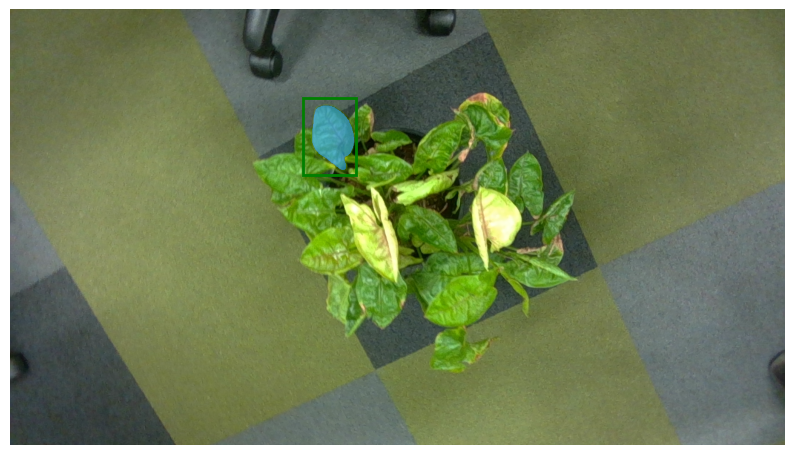

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box[0], plt.gca())
plt.axis('off')
plt.show()

### multiple boxes

In [9]:
input_box

array([[482, 151, 575, 270],
       [397, 235, 536, 316],
       [469, 188, 524, 257],
       [560, 151, 604, 223],
       [589, 197, 667, 241],
       [552, 232, 669, 303],
       [662, 171, 755, 275],
       [417, 287, 469, 331],
       [451, 297, 549, 380],
       [466, 354, 592, 448],
       [510, 437, 587, 549],
       [570, 419, 663, 532],
       [534, 288, 653, 456],
       [639, 389, 667, 406],
       [638, 409, 687, 433],
       [663, 377, 709, 407],
       [630, 322, 745, 408],
       [622, 260, 746, 330],
       [688, 426, 814, 531],
       [672, 399, 807, 504],
       [687, 523, 807, 598],
       [756, 295, 850, 436],
       [862, 294, 948, 381],
       [812, 228, 907, 340],
       [765, 240, 843, 309],
       [721, 266, 771, 336],
       [728, 133, 839, 255],
       [813, 432, 861, 512],
       [786, 376, 955, 463]])

In [10]:
input_boxes = torch.tensor(input_box, device=predictor.device)

In [11]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [12]:
masks.shape 

torch.Size([29, 1, 720, 1280])

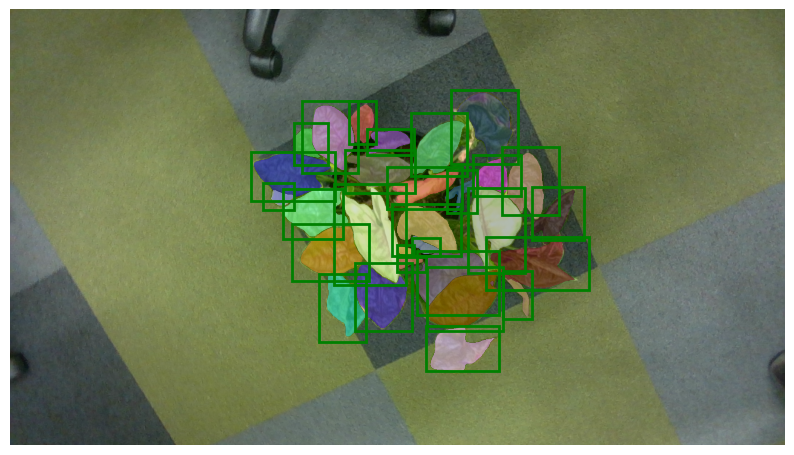

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

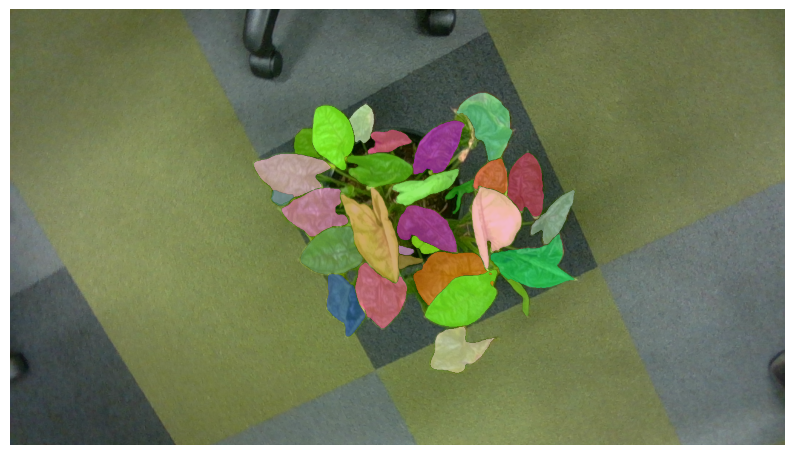

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [24]:
np.save(img_path[:-4]+'_mask.npy', masks.cpu().numpy())

## point prompts

In [ ]:

img_path = './rgb_000001.png'
image_bgr = cv2.imread(img_path)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# Function to be called on mouse events
def click_event(event, x, y, flags, param):
   if event == cv2.EVENT_LBUTTONDOWN:  # Left button click
        print(f"Point selected: ({x}, {y})")
        cv2.circle(temp_img, (x, y), radius=1, color=(0, 255, 0), thickness=-1)  # Mark the selected point on the temp image
        cv2.imshow('image', temp_img)

temp_img = image_bgr.copy()  # Make a temporary copy of the image to draw points on

cv2.imshow('image', image_bgr)

# Set the mouse callback function for the window
cv2.setMouseCallback('image', click_event)

cv2.waitKey(0)  # Wait for a key press to exit
cv2.destroyAllWindows()

In [ ]:
image = cv2.imread('./rgb_000001.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)

In [ ]:
# image_bgr = cv2.imread(img_path)
# image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# Function to be called on mouse events
input_pt = []
def click_event(event, x, y, flags, param):
   if event == cv2.EVENT_LBUTTONDOWN:  # Left button click
        print(f"Point selected: ({x}, {y})")
        input_pt.append([x,y])
        cv2.circle(temp_img, (x, y), radius=1, color=(0, 255, 0), thickness=-1)  # Mark the selected point on the temp image
        cv2.imshow('image', temp_img)

temp_img = image.copy()  # Make a temporary copy of the image to draw points on

cv2.imshow('image', image)

# Set the mouse callback function for the window
cv2.setMouseCallback('image', click_event)

cv2.waitKey(0)  # Wait for a key press to exit
cv2.destroyAllWindows()

In [ ]:
input_pt

In [ ]:
input_point = np.array(input_pt)
input_label = np.array([1])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  